# Import libraries

Use conda env with tensorflow-gpu and keras

This notebook contains the following:

1. Load training data, split and train network
    - find data here:
    https://s3.console.aws.amazon.com/s3/object/gcw-rimbunio-common-input-data-dev/input_data/other/pixel_based_training_data/south_east_asia/
2. Test inference on imagery
    - use GBDX
    - use imagery as tif downloaded from GBDX
    
    
find model example file: https://drive.google.com/drive/u/0/folders/1JXnWrSEp0mTt8JtqWh2ATBzXjkm7ZkVX

    
    
   

In [33]:
# import the necessary packages
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np
import geojson
import dask
import os

import tensorflow as tf
import matplotlib.gridspec as gridspec

from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.models import Input, Model
from keras.layers import Add, Conv2D, Conv2DTranspose

import cv2
import glob
import json
import numpy as np
import rasterio
import earthpy.plot as ep

from datetime import datetime
from functools import partial
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from skimage import filters

# Instantiating an Interface object automatically logs you in to the GBDX platform
from gbdxtools.task import env
from gbdxtools import CatalogImage
from gbdxtools import Interface
gbdx = Interface()

# Get prebuild training dataset

In [2]:
# path = '../../data/trainings_data_waterbodies/data_non_acomp_all_polygons_2020-03-26 12:37:01.698516.csv'
path = '/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/data_non_acomp_all_polygons_2020-03-26 12:37:01.698516.csv'
path = '/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/data_non_acomp_all_polygons_2020-03-21 12_54_09.945770_ONLY_INDONESIA.csv'
# path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/pixel_based_training_data/user_output_3.csv'

# nr_search = path.split('/')[-1].split('_')[4]

# nr_search
# print(nr_search)


# Reading the raw data into a Pandas DataFrame

import pandas as pd

data_raw = pd.read_csv(path).drop('Unnamed: 0', axis = 1).drop(['x','y'], axis= 1)
# data_raw = pd.read_csv(path).drop(['x','y'], axis= 1)

# First we rename the columns of our dataset 

# Bands
# coastal = data[0]
# blue = data[1]
# green = data[2]
# yellow = data[3]
# red = data[4]
# red_edge = data[5]
# nir1 = data[6]
# nir2 = data[7]

    # select variables
property_names = ['cloudCover',
                 'multiResolution',
                 'targetAzimuth',
                 # 'timestamp',
                 'sunAzimuth',
                 'offNadirAngle',
                 # 'platformName',
                 'sunElevation',
                 # 'scanDirection',
                 'panResolution']

data_raw.columns = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names  + ['label']

# Here we will calculate the indices with the band data we already have

data_raw['ndvi'] = (data_raw.nir1 - data_raw.red)/(data_raw.nir1 + data_raw.red)
data_raw['ndwi'] = (data_raw.green - data_raw.nir1)/(data_raw.green + data_raw.nir1)

data_raw['wwi'] = (data_raw.coastal-data_raw.nir2)/(data_raw.coastal+data_raw.nir2+10e-5)

data_clean = data_raw


all_variables = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names + ['ndvi','ndwi', 'wwi']

i = 0 
for variable in all_variables:
    print(i, variable)
    i = i + 1
    
variable_selection = range(17)

all_variables = [all_variables[i] for i in variable_selection]

data = data_clean[all_variables].values

# Normalize training data to between 0 and 1
try:
    min_data =  np.nanmin(data)
    max_data = np.nanmax(data)
    data = (data - min_data) / (max_data - min_data)
except Exception as e:
    print(e)

0 coastal
1 blue
2 green
3 yellow
4 red
5 red_edge
6 nir1
7 nir2
8 cloudCover
9 multiResolution
10 targetAzimuth
11 sunAzimuth
12 offNadirAngle
13 sunElevation
14 panResolution
15 ndvi
16 ndwi
17 wwi


In [3]:
# check data 
data_clean

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,cloudCover,multiResolution,targetAzimuth,sunAzimuth,offNadirAngle,sunElevation,panResolution,label,ndvi,ndwi,wwi
0,1008,877,764,564,510,324,328,188,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.217184,0.399267,0.685619
1,1088,834,625,469,388,262,202,117,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.315254,0.511487,0.805809
2,1326,1141,992,788,692,411,359,224,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.316841,0.468542,0.710968
3,1278,1111,953,710,634,361,328,181,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.318087,0.487900,0.751885
4,1306,1118,955,730,627,358,297,187,4,1.990745,353.37848,42.406155,16.204758,53.59690,0.499102,water,-0.357143,0.525559,0.749498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269399,1468,1191,1085,850,710,1748,2779,2119,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,0.593007,-0.438406,-0.181489
269400,1519,1237,1121,874,741,1827,3206,2534,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,0.624525,-0.481858,-0.250432
269401,1759,1529,1303,1153,1161,986,1065,804,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,-0.043127,0.100507,0.372610
269402,2136,2039,1910,1861,1901,1673,1760,1343,0,1.994957,246.04358,43.313908,16.489162,53.57746,0.500279,non_water,-0.038514,0.040872,0.227939


In [4]:
X = data 

# Similarly, we can extract the labels
y = data_clean['label'].values == 'water'

print(X.shape)
print(X[:,0])

(269404, 17)
[0.08504912 0.09179468 0.11186272 ... 0.14837307 0.18016152 0.14390413]


In [5]:
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0, shuffle=True, stratify=labels)

# First split the data samples into training and validLation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('')
print('Training Data Shape: ', X_train.shape)   # Convert to 2-D tensor -> X_train[nb_samples, nb_channels]
print('Training Data Dtype: ', X_train.dtype)
print('Training Labels Shape: ', y_train.shape) # Convert to 1-D tensor -> y_train[nb_samples]
print('Training Labels Dtype: ', y_train.dtype)

# Second, split the the validation data into validation and testing sets
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.33, random_state=42, stratify=y_validation)

print('')
print('Validation Data Shape: ',X_validation.shape)  # Convert to 2-D tensor -> X_validation[nb_samples, nb_channels]
print('Validation Data Shape: ', X_validation.dtype)
print('Validation Labels: ', y_validation.shape)     # Convert to 1-D tensor -> y_validation[nb_samples]
print('Validation Labels: ', y_validation.dtype)

print('')
print('Test Data Shape: ',X_test.shape)  # Convert to 2-D tensor -> testData[nb_samples, nb_channels]
print('Test Data Shape: ', X_test.dtype)
print('Test Labels: ', y_test.shape)     # Convert to 1-D tensor -> testLabels[nb_samples]
print('Test Labels: ', y_test.dtype)
print(X_train[0,:])


Training Data Shape:  (188582, 17)
Training Data Dtype:  float64
Training Labels Shape:  (188582,)
Training Labels Dtype:  bool

Validation Data Shape:  (54150, 17)
Validation Data Shape:  float64
Validation Labels:  (54150,)
Validation Labels:  bool

Test Data Shape:  (26672, 17)
Test Data Shape:  float64
Test Labels:  (26672,)
Test Labels:  bool
[1.35219223e-01 1.08489942e-01 8.21822589e-02 6.52340397e-02
 5.62961729e-02 4.33952896e-02 3.49633398e-02 2.07133445e-02
 5.50673890e-05 2.23281171e-04 2.08013387e-02 3.70727439e-03
 1.44542526e-03 4.57269195e-03 9.72506634e-05 3.53330383e-05
 8.90867832e-05]


In [6]:
np.savez_compressed('/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_data/train.npz',
                    X_train=X_train,
                    y_train=y_train)
np.savez_compressed('/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_data/validation.npz',
                    X_validation=X_validation,
                    y_validation=y_validation)
np.savez_compressed('/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_data/test.npz',
                    X_test=X_test,
                    y_test=y_test)
np.savez_compressed('/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_data/minMax.npz',
                    min_data=min_data,
                    max_data=max_data)



# Data Exploratory

# SVM Model

In [7]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [8]:
y_pred = svclassifier.predict(X_test)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11697   346]
 [  743 13886]]
              precision    recall  f1-score   support

       False       0.94      0.97      0.96     12043
        True       0.98      0.95      0.96     14629

    accuracy                           0.96     26672
   macro avg       0.96      0.96      0.96     26672
weighted avg       0.96      0.96      0.96     26672



<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


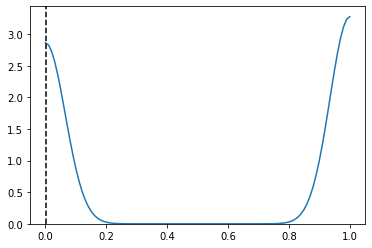

In [10]:
sns.kdeplot(y_pred.flatten(),cut=0);
thresh = filters.threshold_otsu(y_pred)
plt.axvline(thresh, color='k', ls='--');
plt.draw()
plt.show()

### Define the Deep Learning Model.

The model is a shallow multi-layer perceptron (MLP), using only fully-connnected (Dense) layers. We also use dropout layers and ReLu activation. The reason why we used drop-out layers is that we found the model's predictive capability to be less prone to false-alarm on 'blue-topped' buildings or other man-made structures.

In [12]:
# Define the Multi-layer Perceptron (MLP) neural network model
def create_baseline(dimensions):
    # Create model
    model = Sequential()
    model.add(Dense(dimensions, input_dim=dimensions, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(8, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(4, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(2, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    opt = Adam(decay=0.000005)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Display the model summary
    model.summary()

    # Return the newly constructed network architecture
    return model

### Create custom callback to terminate early

This custom Keras callback will terminate early if either the minimal learning rate has been achieved (i.e., plateaus) or the maximum number of Epochs has been reached.

In [13]:
# Create custom callback to terminate early if minimum learning rate 
# has been achieved or the maximum number of Epochs has been reached
class EarlyStoppingByLearningRate(Callback):
    def __init__(self, min_lr=0., max_epochs=100, verbose=0):
        super(Callback, self).__init__()
        self.min_lr = min_lr
        self.max_epochs = max_epochs
        self.verbose = verbose
        self.init_lr=0
        self.curr_lr=0
        self.decay=0
        self.iterations=0

    def on_epoch_end(self, epoch, logs={}):
        self.init_lr = K.get_value(self.model.optimizer.lr)
        self.decay = K.get_value(self.model.optimizer.decay)
        self.iterations = K.get_value(self.model.optimizer.iterations)
        self.curr_lr = self.init_lr * (1. / (1. + self.decay * self.iterations))

        if self.curr_lr < self.min_lr or epoch == self.max_epochs:
            if self.verbose > 0:
                print("The current LR = {0:10.8f} at Epoch = {1:05d}".format(self.curr_lr, epoch))
            self.model.stop_training = True

In [14]:
# Specify the list of training 'batch' sizes
batch_sizes = [200] # [200, 300, 400, 500] # [100]
n_samples, dimensions= X.shape

verbose = 1

for (cnt, batch_size) in enumerate(batch_sizes):

    print("Training the water-land classes predictive model ...")

    # Load our MLP binary classifier model
    model = create_baseline(dimensions) # create_baseline2(800, 800, transfer_learning = True, l_r = 0.0001)

    # Specify the minimum learning rate, the maximum number of epochs, and the batch size
    min_learning_rate = 0.000001
    max_epochs = 50

    # Use reduce learning rate if validation loss plateaus
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  verbose=verbose,
                                  factor=0.1,
                                  patience=25,
                                  min_lr=min_learning_rate)

    # Use checkpointer callback to save the model everytime the validation accuracy increases
    weights = '/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_models/bfalg_' + 'batchSize_' + str(batch_size) + '_Epoch-{epoch:05d}-Val_acc-{accuracy:.5f}_' + 'weights.hdf5'
    checkpointer = ModelCheckpoint(weights, 
                                   monitor='accuracy', 
                                   verbose=verbose,
                                   save_best_only=True,
                                   mode='max')

    # Early stopping by learning rate callback
    earlyStop = EarlyStoppingByLearningRate(min_lr=min_learning_rate, 
                                            max_epochs=max_epochs,
                                            verbose=verbose)

    # Create list of all of the callbacks
    callbacks_list = [reduce_lr, checkpointer, earlyStop]
    
    history = model.fit(X_train, 
                        y_train,
                        batch_size=batch_size,
                        epochs=max_epochs, 
                        callbacks=callbacks_list,
                        shuffle=True,
                        validation_data=(X_validation, y_validation))
    
    # Evaluate and display the accuracy using the test data
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

    # Output the loss and accuracy on the held-out testing set
    print()
    print("Test loss: {:.4f}%".format(loss))
    print("Test accuracy: {:.4f}%".format(accuracy * 100))
    
    # List all data in history
    print(history.history.keys())

Training the water-land classes predictive model ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 17)                306       
_________________________________________________________________
dropout_2 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                288       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
d

Epoch 21/50
188582/188582 [==============================] - 1s 6us/step - loss: 0.1349 - accuracy: 0.9452 - val_loss: 0.1116 - val_accuracy: 0.9493

Epoch 00021: accuracy improved from 0.94423 to 0.94523, saving model to /home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_models/bfalg_batchSize_200_Epoch-00021-Val_acc-0.94523_weights.hdf5
Epoch 22/50
188582/188582 [==============================] - 1s 7us/step - loss: 0.1317 - accuracy: 0.9473 - val_loss: 0.1088 - val_accuracy: 0.9508

Epoch 00022: accuracy improved from 0.94523 to 0.94734, saving model to /home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_models/bfalg_batchSize_200_Epoch-00022-Val_acc-0.94734_weights.hdf5
Epoch 23/50
188582/188582 [==============================] - 1s 7us/step - loss: 0.1316 - accuracy: 0.9478 - val_loss: 0.1101 - val_accuracy: 0.9512

Epoch 00023: accuracy improved from 0.94734 to 0.94785, saving model to /home/daffolap-851/Projects/GreenCityWatch/pixel

Epoch 47/50
188582/188582 [==============================] - 1s 7us/step - loss: 0.1101 - accuracy: 0.9573 - val_loss: 0.0813 - val_accuracy: 0.9710

Epoch 00047: accuracy did not improve from 0.95765
Epoch 48/50
188582/188582 [==============================] - 1s 8us/step - loss: 0.1090 - accuracy: 0.9580 - val_loss: 0.0912 - val_accuracy: 0.9681

Epoch 00048: accuracy improved from 0.95765 to 0.95802, saving model to /home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_models/bfalg_batchSize_200_Epoch-00048-Val_acc-0.95802_weights.hdf5
Epoch 49/50
188582/188582 [==============================] - 1s 8us/step - loss: 0.1087 - accuracy: 0.9578 - val_loss: 0.0946 - val_accuracy: 0.9583

Epoch 00049: accuracy did not improve from 0.95802
Epoch 50/50
188582/188582 [==============================] - 1s 8us/step - loss: 0.1096 - accuracy: 0.9572 - val_loss: 0.0864 - val_accuracy: 0.9658

Epoch 00050: accuracy did not improve from 0.95802
26672/26672 [===================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


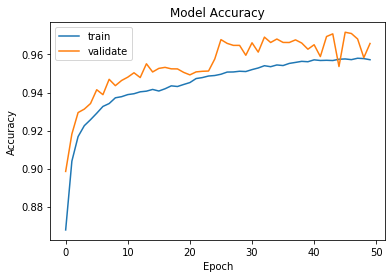

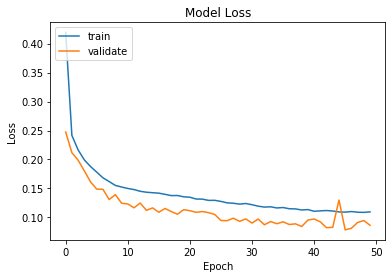

In [15]:
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.draw()
plt.show()
plt.pause(1)    

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.draw()
plt.show()
plt.pause(1)

In [16]:
y_pred = model.predict(X_test)

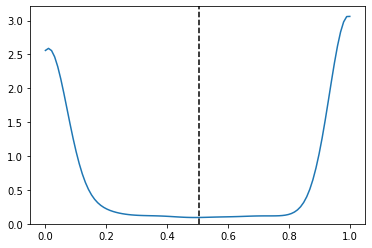

In [17]:
sns.kdeplot(y_pred.flatten(),cut=0);
thresh = filters.threshold_otsu(y_pred)
plt.axvline(thresh, color='k', ls='--');
plt.draw()
plt.show()


In [18]:
print('Otsu Threshold:', thresh)
print('Precision Score:', precision_score(y_test, y_pred>thresh))
print('Recall Score:', recall_score(y_test, y_pred > thresh))
print('F1-Score:', f1_score(y_test, y_pred > thresh))

Otsu Threshold: 0.5058008
Precision Score: 0.987280608256946
Recall Score: 0.9497573313281837
F1-Score: 0.9681555292314125


## visualize model

In [27]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

from ann_visualizer.visualize import ann_viz;
import numpy


ann_viz(model, title="Artificial Neural network - Model Visualization")

# Do inference

In [21]:
# load model
from keras.models import load_model


path = '/home/daffolap-851/Projects/GreenCityWatch/pixel_based_training_data/bfalg_models/bfalg_batchSize_200_Epoch-00048-Val_acc-0.95802_weights.hdf5'
# path = '/home/daffolap-851/Projects/GreenCityWatch/manual_inference_data_and_weights/pre_trained_model_weights/bfalg_batchSize_200_Epoch-00185-Val_acc-0.95145_weights.hdf5'
model = load_model(path)

In [22]:
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_local
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd

from gbdxtools import Interface
gbdx = Interface()

In [23]:
def rgb_from_raster(data, brightness):
    
    bands, x, y = data.shape
    
    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    if rgb.mean() > 1:
        rgb[rgb > 255] = 255
    else: 
        rgb[rgb > 1] = 1
    
    return rgb

# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

## Use raster file

Start here when using imagery downloaded from s3

Find data in following bucket: https://s3.console.aws.amazon.com/s3/buckets/gcw-rimbunio-common-input-data-dev/input_data/imagery/

In [24]:
# find files in imagery folder
import glob
name = ''
save_classification = True

raster_files_path = '/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/*.tif'
raster_files = glob.glob(raster_files_path)
file_path = raster_files[0]

print(len(raster_files))
print('-------------------------------------')
print(raster_files[0:5])
print('-------------------------------------')
print(file_path)


5
-------------------------------------
['/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_rawa_indah_2018-09-13_03_30_1030010085B5FC00.tif', '/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_rawa_babon_2019-07-27_03_34_10400100503B3A00.tif', '/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_Babakan_S_2019-05-31_03_28_104001004CBD1F00.tif', '/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_mangga_bolong_2019-05-31_03_28_104001004CBD1F00.tif', '/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif']
-------------------------------------
/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_rawa_indah_2018-09-13_03_30_1030010085B5FC00.tif


In [25]:
if len(raster_files) == 1:
    sample_size = 1
else:
    sample_size = 5

/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_Babakan_S_2019-05-31_03_28_104001004CBD1F00.tif
2146013/2146013 [==============================] - 18s 9us/step


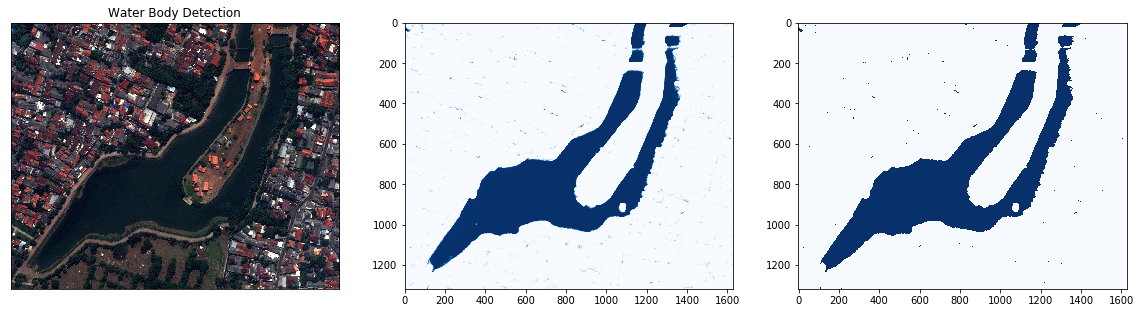

saved as:  /home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/raster_classifications/classification_Setu_Babakan_S_2019-05-31_03_28_104001004CBD1F00.tif
/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_rawa_indah_2018-09-13_03_30_1030010085B5FC00.tif
1361889/1361889 [==============================] - 12s 9us/step


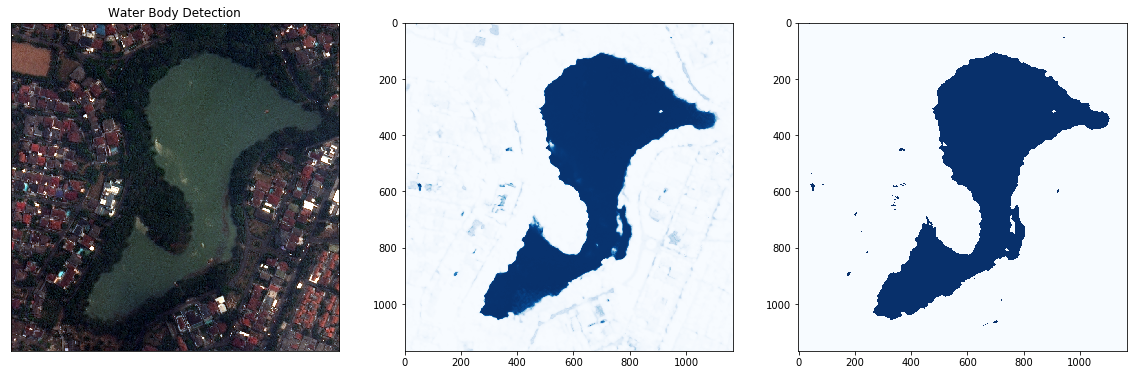

saved as:  /home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/raster_classifications/classification_Setu_rawa_indah_2018-09-13_03_30_1030010085B5FC00.tif
/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif
7388599/7388599 [==============================] - 62s 8us/step


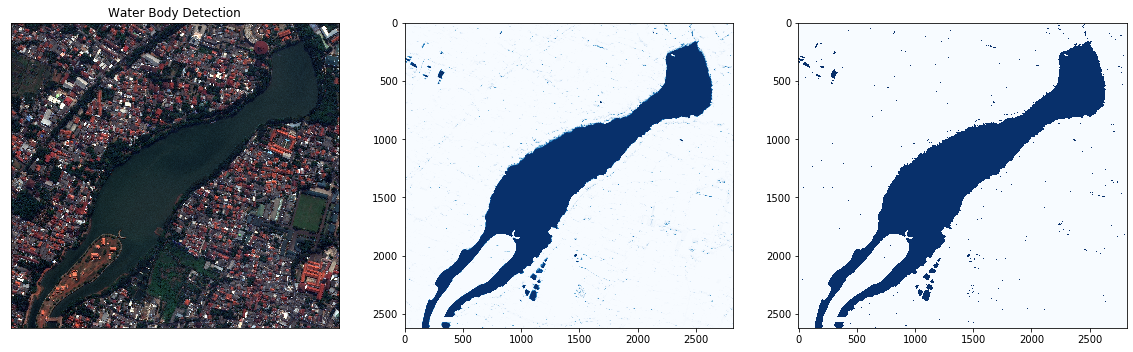

saved as:  /home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/raster_classifications/classification_Setu_Babakan_N_2019-05-31_03_28_104001004CBD1F00.tif
/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_mangga_bolong_2019-05-31_03_28_104001004CBD1F00.tif
3545718/3545718 [==============================] - 33s 9us/step


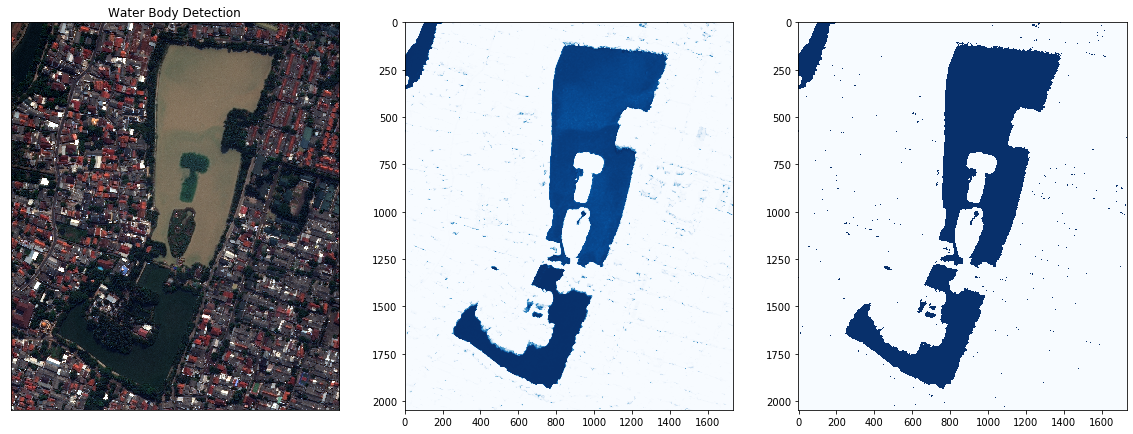

saved as:  /home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/raster_classifications/classification_Setu_mangga_bolong_2019-05-31_03_28_104001004CBD1F00.tif
/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_rawa_babon_2019-07-27_03_34_10400100503B3A00.tif
3036682/3036682 [==============================] - 26s 9us/step 


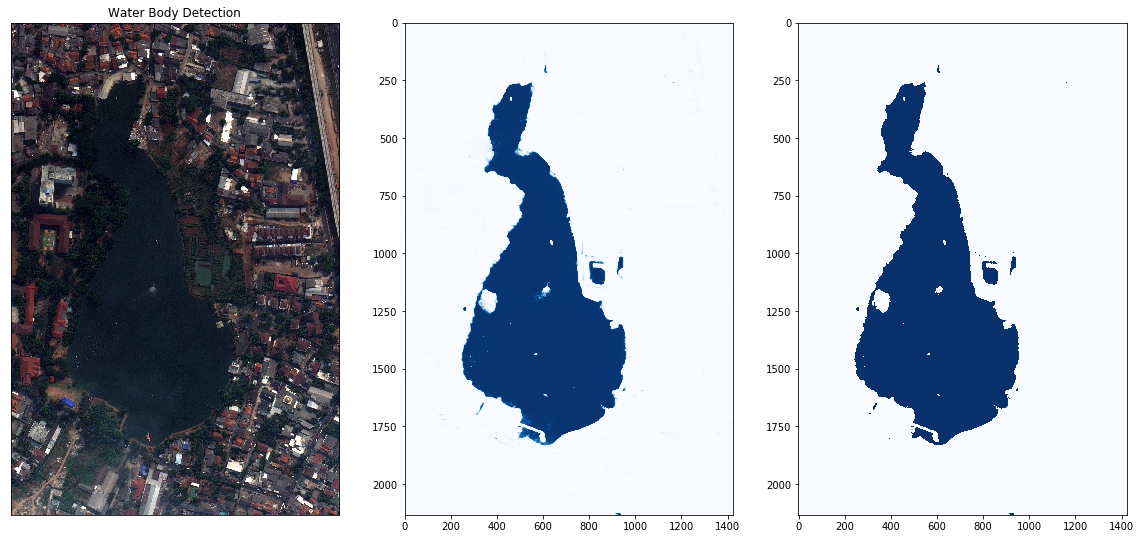

saved as:  /home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/raster_classifications/classification_Setu_rawa_babon_2019-07-27_03_34_10400100503B3A00.tif


In [34]:

for file_path in np.array(pd.DataFrame(raster_files).sample(sample_size)).flatten(): 
    
    print(file_path)
    filename = file_path.split('/')[-1]

    import rasterio

    data = rasterio.open(file_path).read()
    dataset = rasterio.open(file_path)

    transform = dataset.meta['transform']
    width = dataset.meta['width']
    height = dataset.meta['height']

    # Split image data into band layers
    coastal = data[0] 
    blue    = data[1]
    green   = data[2]
    yellow  = data[3]
    red     = data[4] 
    red_edge = data[5] 
    nir1 = data[6]
    nir2 = data[7]
    
    # get info from filenames
    stringlist = file_path.split('/')[-1].split('_')
    image_id = stringlist[-1].split('.')[0]

    # get metadata from GBDX
    record = gbdx.catalog.get(image_id)

    # add metadata to data 
    i = 8
    for property_name in property_names:

            try: 
                property_record = record['properties'][property_name]  

                property_array = np.empty([1,data.shape[1],data.shape[2]])
                property_array.fill(property_record)

                data = np.vstack([data,property_array])
            except: 
                print('failed ', property_name, image_id)
                property_array = np.empty([1,data.shape[1],data.shape[2]])
                data = np.vstack([data,property_array])

            i = i + 1


    # Calculate indices
    # Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
    ndvi = reshape((nir1 - red)/(nir1 + red))
    ndwi = reshape((green - nir1) / (green + nir1))
    wwi = reshape((coastal - nir2) / (coastal + nir2 + 10e-5))

    # Stack arrays in sequence vertically (row wise)
    image_array = np.vstack([data,ndvi,ndwi, wwi])
    # select all variables of interest
    image_array = image_array[variable_selection,:,:]

    ### Reshape the data prior to feeding it through the model.
    # Flatten the two-dimensional imagery (i.e., Reshape)
    d2, h2, w2 = image_array.shape
    data_pred = np.reshape(image_array,(d2,h2*w2)).T

    # Convert data type to 32-bit float, and normalize between 0 and 1
    data_pred.astype(np.float32)
    data_pred = (data_pred - min_data) / (max_data - min_data)

    # Next, conduct model prediction on each spectral column
    labels_pred = model.predict(data_pred, verbose = 1, workers = 4)
    labels_pred = np.reshape(labels_pred,(h2,w2))

    ### Calculate threshold for classification  
    thresh = filters.threshold_otsu(labels_pred)

    ### Plot the input image alongside its corresponding predictions.
    plt.figure(figsize=(20,20))
    ax = plt.subplot(131)

    # Plot CIR image using the raster extent
# ----------------------------------------------------------------------------------------------------#    
    ep.plot_rgb(
        data,
        rgb=(4, 2, 1),
        stretch=True,
        ax=ax,
        str_clip=0.5,
        title="Water Body Detection",
    )
    plt.subplot(132);plt.imshow(labels_pred, cmap = 'Blues');
    # plt.colorbar()
    plt.subplot(133);plt.imshow(labels_pred > 0.4, cmap = 'Blues');
    plt.draw()
    plt.show()
# ------------------------------------------------------------------------------------------------------#

    ### save classifications to raster
    labels_pred = labels_pred.astype(float)
    
    array_classification = labels_pred > thresh
    array_classification = array_classification.astype(float)
    
    classification_filename = '/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/raster_classifications/classification_' + filename
    
    
    if save_classification:
        with rasterio.open(
            classification_filename,
            'w',
            driver='GTiff',
            height=labels_pred.shape[0],
            width=labels_pred.shape[1],
            count=1,
            dtype=labels_pred.dtype,
            crs='+proj=latlong',
            transform=transform,
        ) as dst:
            dst.write(labels_pred, 1)


        print('saved as: ', classification_filename)


In [ ]:

for file_path in np.array(pd.DataFrame(raster_files).sample(sample_size)).flatten(): 
    
    print(file_path)
    filename = file_path.split('/')[-1]

    import rasterio

    data = rasterio.open(file_path).read()
    dataset = rasterio.open(file_path)

    transform = dataset.meta['transform']
    width = dataset.meta['width']
    height = dataset.meta['height']

    # Split image data into band layers
    coastal = data[0] 
    blue    = data[1]
    green   = data[2]
    yellow  = data[3]
    red     = data[4] 
    red_edge = data[5] 
    nir1 = data[6]
    nir2 = data[7]
    
    # get info from filenames
    stringlist = file_path.split('/')[-1].split('_')
    image_id = stringlist[-1].split('.')[0]

    # get metadata from GBDX
    record = gbdx.catalog.get(image_id)

    # add metadata to data 
    i = 8
    for property_name in property_names:

            try: 
                property_record = record['properties'][property_name]  

                property_array = np.empty([1,data.shape[1],data.shape[2]])
                property_array.fill(property_record)

                data = np.vstack([data,property_array])
            except: 
                print('failed ', property_name, image_id)
                property_array = np.empty([1,data.shape[1],data.shape[2]])
                data = np.vstack([data,property_array])

            i = i + 1


    # Calculate indices
    # Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
    ndvi = reshape((nir1 - red)/(nir1 + red))
    ndwi = reshape((green - nir1) / (green + nir1))
    wwi = reshape((coastal - nir2) / (coastal + nir2 + 10e-5))

    # Stack arrays in sequence vertically (row wise)
    image_array = np.vstack([data,ndvi,ndwi, wwi])
    # select all variables of interest
    image_array = image_array[variable_selection,:,:]

    ### Reshape the data prior to feeding it through the model.
    # Flatten the two-dimensional imagery (i.e., Reshape)
    d2, h2, w2 = image_array.shape
    data_pred = np.reshape(image_array,(d2,h2*w2)).T

    # Convert data type to 32-bit float, and normalize between 0 and 1
    data_pred.astype(np.float32)
    data_pred = (data_pred - min_data) / (max_data - min_data)

    # Next, conduct model prediction on each spectral column
#     labels_pred = model.predict(data_pred, verbose = 1, workers = 4)
    labels_pred = svclassifier.predict(data_pred)
    labels_pred = np.reshape(labels_pred,(h2,w2))

    ### Calculate threshold for classification  
    thresh = filters.threshold_otsu(labels_pred)

    ### Plot the input image alongside its corresponding predictions.
    plt.figure(figsize=(20,20))
    plt.subplot(131);plt.imshow(rgb_from_raster(data, 0.0)); plt.title(filename)
    plt.subplot(132);plt.imshow(labels_pred, cmap = 'Blues');
    # plt.colorbar()
    plt.subplot(133);plt.imshow(labels_pred > 0.4, cmap = 'Blues');
    plt.draw()
    plt.show()
    
    ### save classifications to raster
    labels_pred = labels_pred.astype(float)
    
    array_classification = labels_pred > thresh
    array_classification = array_classification.astype(float)
    
    classification_filename = '/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/raster_classifications/classification_' + filename
    
    
    if save_classification:
        with rasterio.open(
            classification_filename,
            'w',
            driver='GTiff',
            height=labels_pred.shape[0],
            width=labels_pred.shape[1],
            count=1,
            dtype=labels_pred.dtype,
            crs='+proj=latlong',
            transform=transform,
        ) as dst:
            dst.write(labels_pred, 1)


        print('saved as: ', classification_filename)


/home/daffolap-851/Projects/GreenCityWatch/img_data_to_combine/Setu_Babakan_S_2019-05-31_03_28_104001004CBD1F00.tif


In [ ]:
# write probabilities raster to file

with rasterio.open(
    classification_filename,
    'w',
    driver='GTiff',
    height=labels_pred.shape[0],
    width=labels_pred.shape[1],
    count=1,
    dtype=labels_pred.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(labels_pred, 1)


print('saved as: ', classification_filename)

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(labels_pred, cmap = 'Blues')

## If no data: Get data from GBDX

Skip this part if you have downloaded imagery from s3

In [ ]:
# get setu babakan data and write to geotiff

# rawa indah = 106.885, -6.36, 106.89, -6.355 , 1030010085B5FC00
# rawa babon = 106.884, -6.341, 106.888, -6.335, 10400100503B3A00

# manila test = 121.004, 14.531, 121.007, 14.535 , 10300100A4711D00

# Shenzen = 114.07, 22.533, 114.074, 22.536 , 10300100A3350C00

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1030010085B5FC00')
bbox = env.inputs.get('bbox', '121.006, 14.535, 121.009, 14.537 ')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")), pansharpen = True)


import datetime



image_id = catalog_id

# Get timestamp
time_image = image.metadata["image"]["acquisitionDate"] 

# convert timestamp to datetime timestamp format
time_image = datetime.datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")
    
time_image_str = time_image.strftime('%Y-%m-%d_%H:%M')



In [ ]:
name = 'Manila_roofs'

In [ ]:
path = "../../TreeTect/data/rasters_waterbodies_osm/{}_{}_{}.tif".format(name,time_image_str,image_id)

path

tif = image.geotiff(
    path = path
                 )

In [ ]:
path